#### Exercise 1 - Kaggle Small Dataset - Congressional Voting

This dataset contains information on different congress members. The goal here is to analyze the data and predict the part of the congress member. 

##### Important Libraries

In [333]:
import pandas as pd
import numpy as np
from scipy.io import arff
import seaborn as sns
import matplotlib.pyplot as plt
import openml


#sklearn
from sklearn.model_selection import train_test_split 
from sklearn import tree
from sklearn.metrics import recall_score,accuracy_score,confusion_matrix, ConfusionMatrixDisplay, precision_score, make_scorer,balanced_accuracy_score
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV,RandomizedSearchCV


#### Loading the data

In [334]:
# train data
congress_train = pd.read_csv('data/congress/CongressionalVotingID.shuf.lrn.csv')

#test data

X_test = pd.read_csv('data/congress/CongressionalVotingID.shuf.tes.csv')


# test result

y_test =  pd.read_csv('data/congress/CongressionalVotingID.shuf.sol.ex.csv')

#### Data exploration and preprocessing

In [3]:
# Number of samples and number of attributes
num_samples = congress_train.shape[0]
num_attributes = congress_train.shape[1] - 1 # last one is the class annotation
print("The number of samples is: ", str(num_samples))
print("The number of attributes is: ", str(num_attributes))

The number of samples is:  218
The number of attributes is:  17


In [4]:
# print number of unknown values:
num_unknown = 0
for n in congress_train.columns:
  num_unknown_per_feature = congress_train.loc[:,n].isin(['unknown']).sum(axis=0)
  num_unknown += num_unknown_per_feature
  print(n, ':', num_unknown_per_feature)
print('total unknown:', num_unknown)

#for the moment, I decided to keep these missing values as they are

ID : 0
class : 0
handicapped-infants : 7
water-project-cost-sharing : 21
adoption-of-the-budget-resolution : 4
physician-fee-freeze : 6
el-salvador-aid : 9
religious-groups-in-schools : 5
anti-satellite-test-ban : 6
aid-to-nicaraguan-contras : 10
mx-missile : 12
immigration : 4
synfuels-crporation-cutback : 13
education-spending : 16
superfund-right-to-sue : 14
crime : 7
duty-free-exports : 14
export-administration-act-south-africa : 58
total unknown: 206


In [5]:
#missing values
congress_train.isna().sum()

ID                                        0
class                                     0
handicapped-infants                       0
water-project-cost-sharing                0
adoption-of-the-budget-resolution         0
physician-fee-freeze                      0
el-salvador-aid                           0
religious-groups-in-schools               0
anti-satellite-test-ban                   0
aid-to-nicaraguan-contras                 0
mx-missile                                0
immigration                               0
synfuels-crporation-cutback               0
education-spending                        0
superfund-right-to-sue                    0
crime                                     0
duty-free-exports                         0
export-administration-act-south-africa    0
dtype: int64

In [6]:
#types of features
congress_train.dtypes

ID                                         int64
class                                     object
handicapped-infants                       object
water-project-cost-sharing                object
adoption-of-the-budget-resolution         object
physician-fee-freeze                      object
el-salvador-aid                           object
religious-groups-in-schools               object
anti-satellite-test-ban                   object
aid-to-nicaraguan-contras                 object
mx-missile                                object
immigration                               object
synfuels-crporation-cutback               object
education-spending                        object
superfund-right-to-sue                    object
crime                                     object
duty-free-exports                         object
export-administration-act-south-africa    object
dtype: object

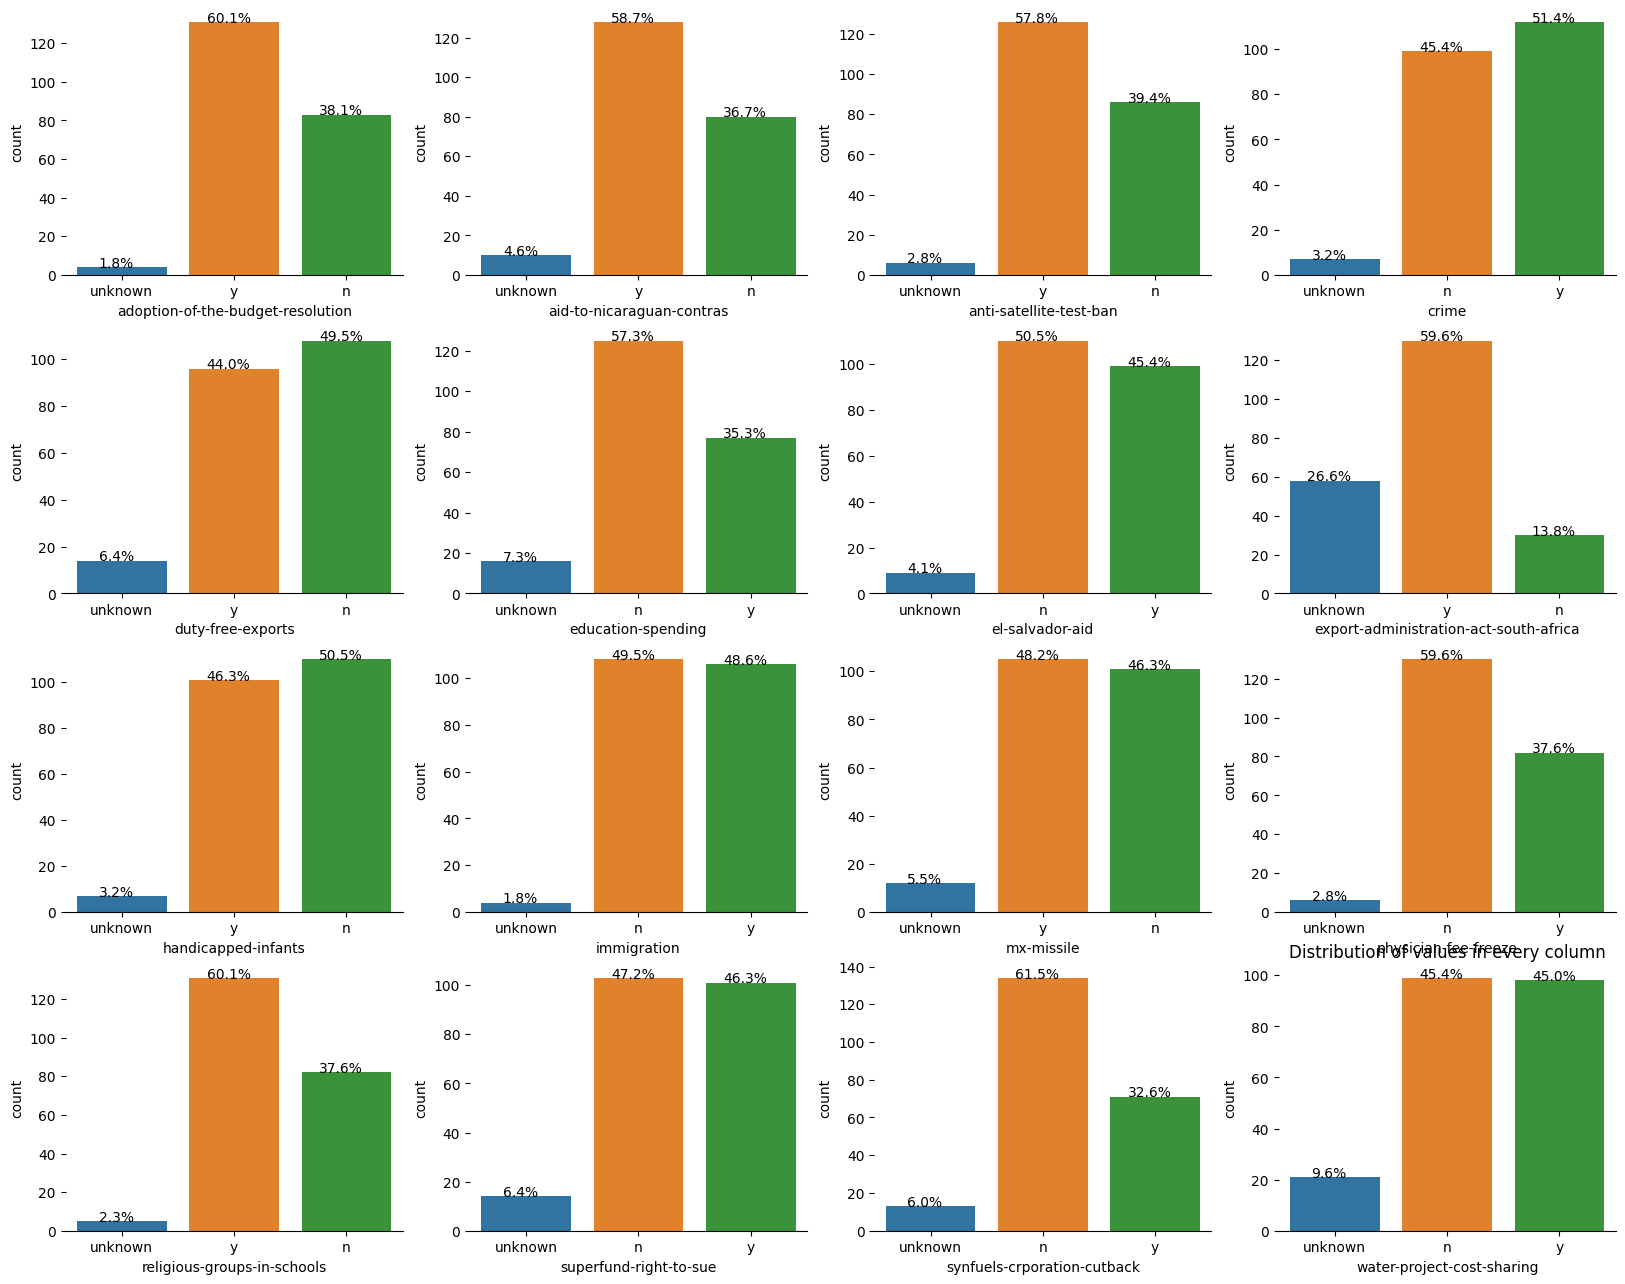

In [7]:
# Plotting the categorical variables
categorical_columns = congress_train.columns.difference(['ID','class'])
plt.figure(figsize=(20,20))
for i, variable in enumerate(categorical_columns):
                     plt.subplot(5,4,i+1)
                     order = congress_train[variable].value_counts(ascending=False).index 
                     ax=sns.countplot(x=congress_train[variable], data=congress_train )
                     sns.despine(top=True,right=True,left=True)
                     for p in ax.patches:
                           percentage = '{:.1f}%'.format(100 * p.get_height()/len(congress_train[variable]))
                           x = p.get_x() + p.get_width() / 2 - 0.05
                           y = p.get_y() + p.get_height()
                           plt.annotate(percentage, (x, y),ha='center')

plt.title('Distribution of values in every column')
plt.show()


Observations:
- `60.1%` of the congressmen voted  for `adoption-of-the-budget-resolution`.
- `58.7%`of the congressmen voted  with `aid-to-nicaraguan-contras`.
- `57.8%`of the congressmen agree with `anti-satellite-test-ban`.
- In the `crime` column `45.4%` have voted against and `51.4%` have voted for. 
- `education-spending` divides the congressmen into `57.3%` no and `35.3%` yes.
- In `duty-free-exports` and `handicapped-infants` the difference between category yes and no is almost 5 in favor of no.
- In `immigration, mix-missile, superfun-right-to-sue and water-project-cost-sharing` the majority have voted against.
- In `superfund-right-to-sue` and `physician-fee-freeze` the majority of votes falls into no category.
- `60.1%` of congressmen voted for `religious-groups-schools`.

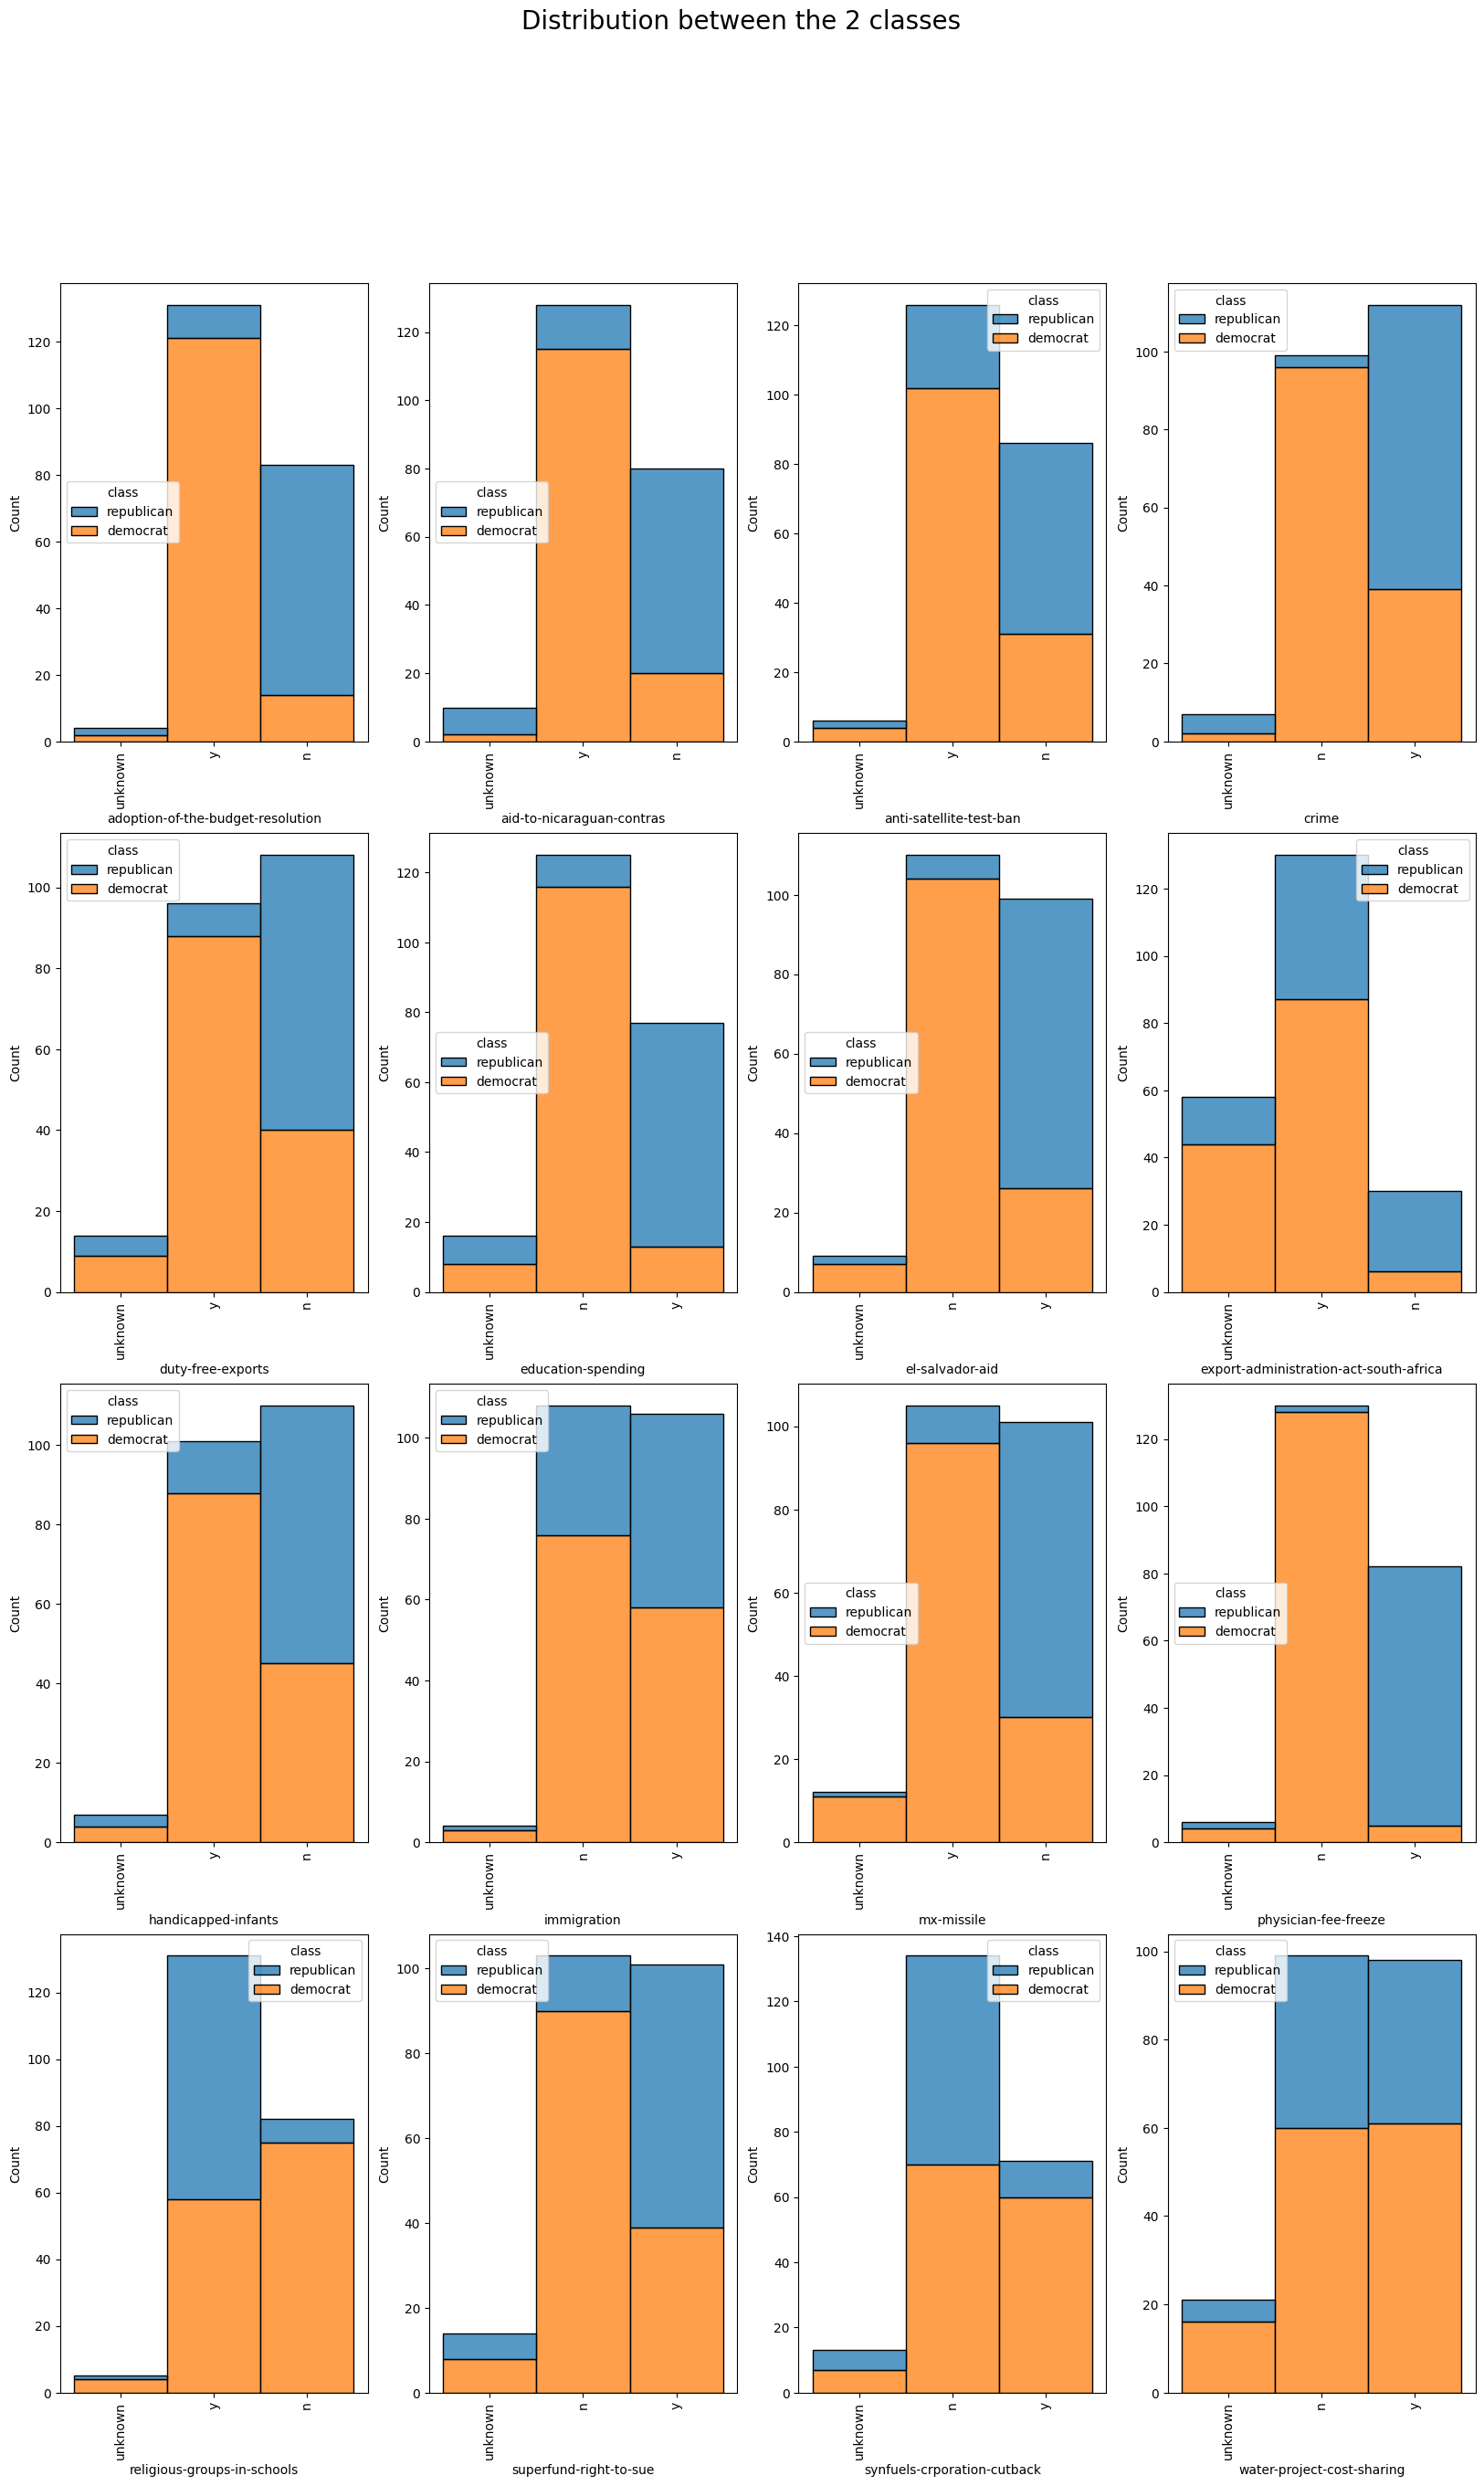

In [8]:

plt.figure(figsize=(20,30))
for i,column in enumerate(categorical_columns):
    plt.subplot(4, 4, i+1)
    sns.histplot(x=congress_train[column],hue =congress_train['class'],multiple = 'stack')
    plt.xlabel(column)
    plt.xticks(rotation=90)
plt.suptitle("Distribution between the 2 classes ", fontsize=20)
plt.show()

Observations:

- The majority of congressmen that have voted for `adoption-of-the-budget-resolution` are democrat
- The majority of congressmen that have voted for `aid-to-nicaragua-contras` are democrat
- The majority of congressmen that have voted for `anti-satellite-test-ban` are democrat
- The majority of congressmen that have voted for `crime` bill are republican
- The majority of congressmen that have voted for `duty-free-exports`are democrat
- The majority of congressmen that have voted for `education-spending` are republican
- The majority of congressmen that have voted for `el-salvador-aid` aew republican
- etc..







##### Preparing data for model fitting

##### Train

In [335]:
X_train = pd.get_dummies(congress_train, columns= categorical_columns)


`ID column`

In [336]:
# dropping this column since it does not bring any value
X_train.drop('ID', axis=1, inplace=True)

`Class column`

In [337]:
X_train['class'] = X_train['class'].map({'democrat': 1, 'republican': 0})
X_train['class'] = X_train['class'].astype('int64')

In [338]:

y_train = X_train['class']
X_train = X_train.drop(['class'], axis=1)

#### Test

In [339]:
categorical_columns_test = X_test.columns.difference(['ID'])
X_test = pd.get_dummies(X_test, columns= categorical_columns_test)

In [340]:
y_test = y_test.drop(['ID'], axis=1)
X_test = X_test.drop(['ID'], axis=1)


In [341]:
y_test['class'] = y_test['class'].map({'democrat': 1, 'republican': 0})
y_test['class'] = y_test['class'].astype('int64')
y_test = y_test.squeeze()

### Decision Trees

In [343]:
#Counting the number of samples for each class
print("Number of samples that belong to republican: ", str(len(congress_train[congress_train['class']=='republican'])),len(congress_train[congress_train['class']=='republican'])/len(congress_train), '%')
print("Number of samples that belong to democrat: ", str(len(congress_train[congress_train['class']=='democrat'])),len(congress_train[congress_train['class']=='democrat'])/len(congress_train), '%')

Number of samples that belong to republican:  81 0.37155963302752293 %
Number of samples that belong to democrat:  137 0.6284403669724771 %


- Our dataset is  imbalanced. 63% of the data is represented by democrat congressmen and 37% by repunlican democrats. Since this may have a massive effect on our prediction and the decision trees will surely be biased toward the dominant class, we can make use of the `class_weight` parameter of the model.

#### Fitting Tree 1

In [344]:
tree_1 = tree.DecisionTreeClassifier(random_state=1)

In [347]:
def evaluate(model,X_train = X_train,X_test = X_test,y_train = y_train,y_test=y_test):
    model.fit(X_train,y_train)
    y_train_predict = model.predict(X_train)
    y_test_predict = model.predict(X_test)

    # accuracy
    print("#"*20)
    print("Accuracy on train: ", accuracy_score(y_train, y_train_predict))
    print("Accuracy on test: ", accuracy_score(y_test, y_test_predict))
    

    print("#"*20)
    print("Recall on train: ", recall_score(y_true = y_train, y_pred = y_train_predict))
    print("Recall on test: ", recall_score(y_true = y_test, y_pred = y_test_predict))
    print("#"*20)
    print("Precision on train: ", precision_score(y_true = y_train, y_pred = y_train_predict))
    print("Precision on test: ", precision_score(y_true = y_test, y_pred = y_test_predict))


    # plot confusion matrices
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    c_1 = confusion_matrix(y_true=y_train, y_pred=y_train_predict)
    cmd_1 = ConfusionMatrixDisplay(c_1, display_labels=['republican','democrat'])
    cmd_1.plot(ax=ax[0], cmap=plt.cm.Blues)
    ax[0].set_title("Confusion matrix: train data")

    c_2 = confusion_matrix(y_true=y_test, y_pred=y_test_predict)
    cmd_2 = ConfusionMatrixDisplay(c_2, display_labels=['republican','democrat'])
    cmd_2.plot(ax=ax[1], cmap=plt.cm.Blues)
    ax[1].set_title("Confusion matrix: test data")

    plt.show()
      
 

####################
Accuracy on train:  1.0
Accuracy on test:  0.5529953917050692
####################
Recall on train:  1.0
Recall on test:  0.5529953917050692
####################
Precision on train:  1.0
Precision on test:  1.0


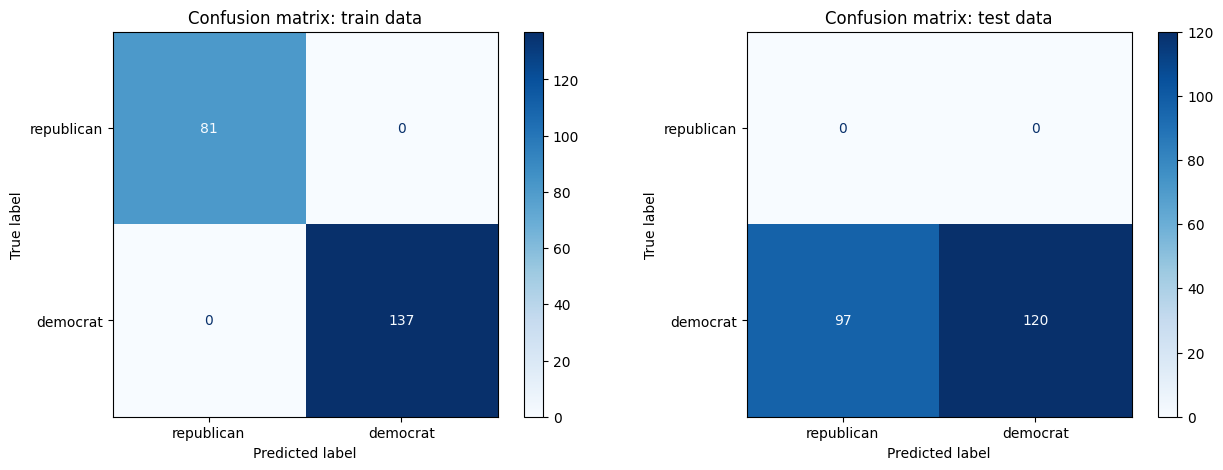

In [348]:
evaluate(tree_1)

Observations:
- As seen above, the accuracy score on the train set is perfect which suggests that our model is highly overfitted

In [349]:
#features of the model
features = list(X_train)

In [350]:
def plottree(model):
    plt.figure(figsize=(20,30))
    plot = tree.plot_tree(model,feature_names=features,filled=True,fontsize=9,node_ids=True,class_names=True)
    for o in plot:
        arrow = o.arrow_patch
        if arrow is not None:
            arrow.set_edgecolor('black')
            arrow.set_linewidth(1)
    plt.show()

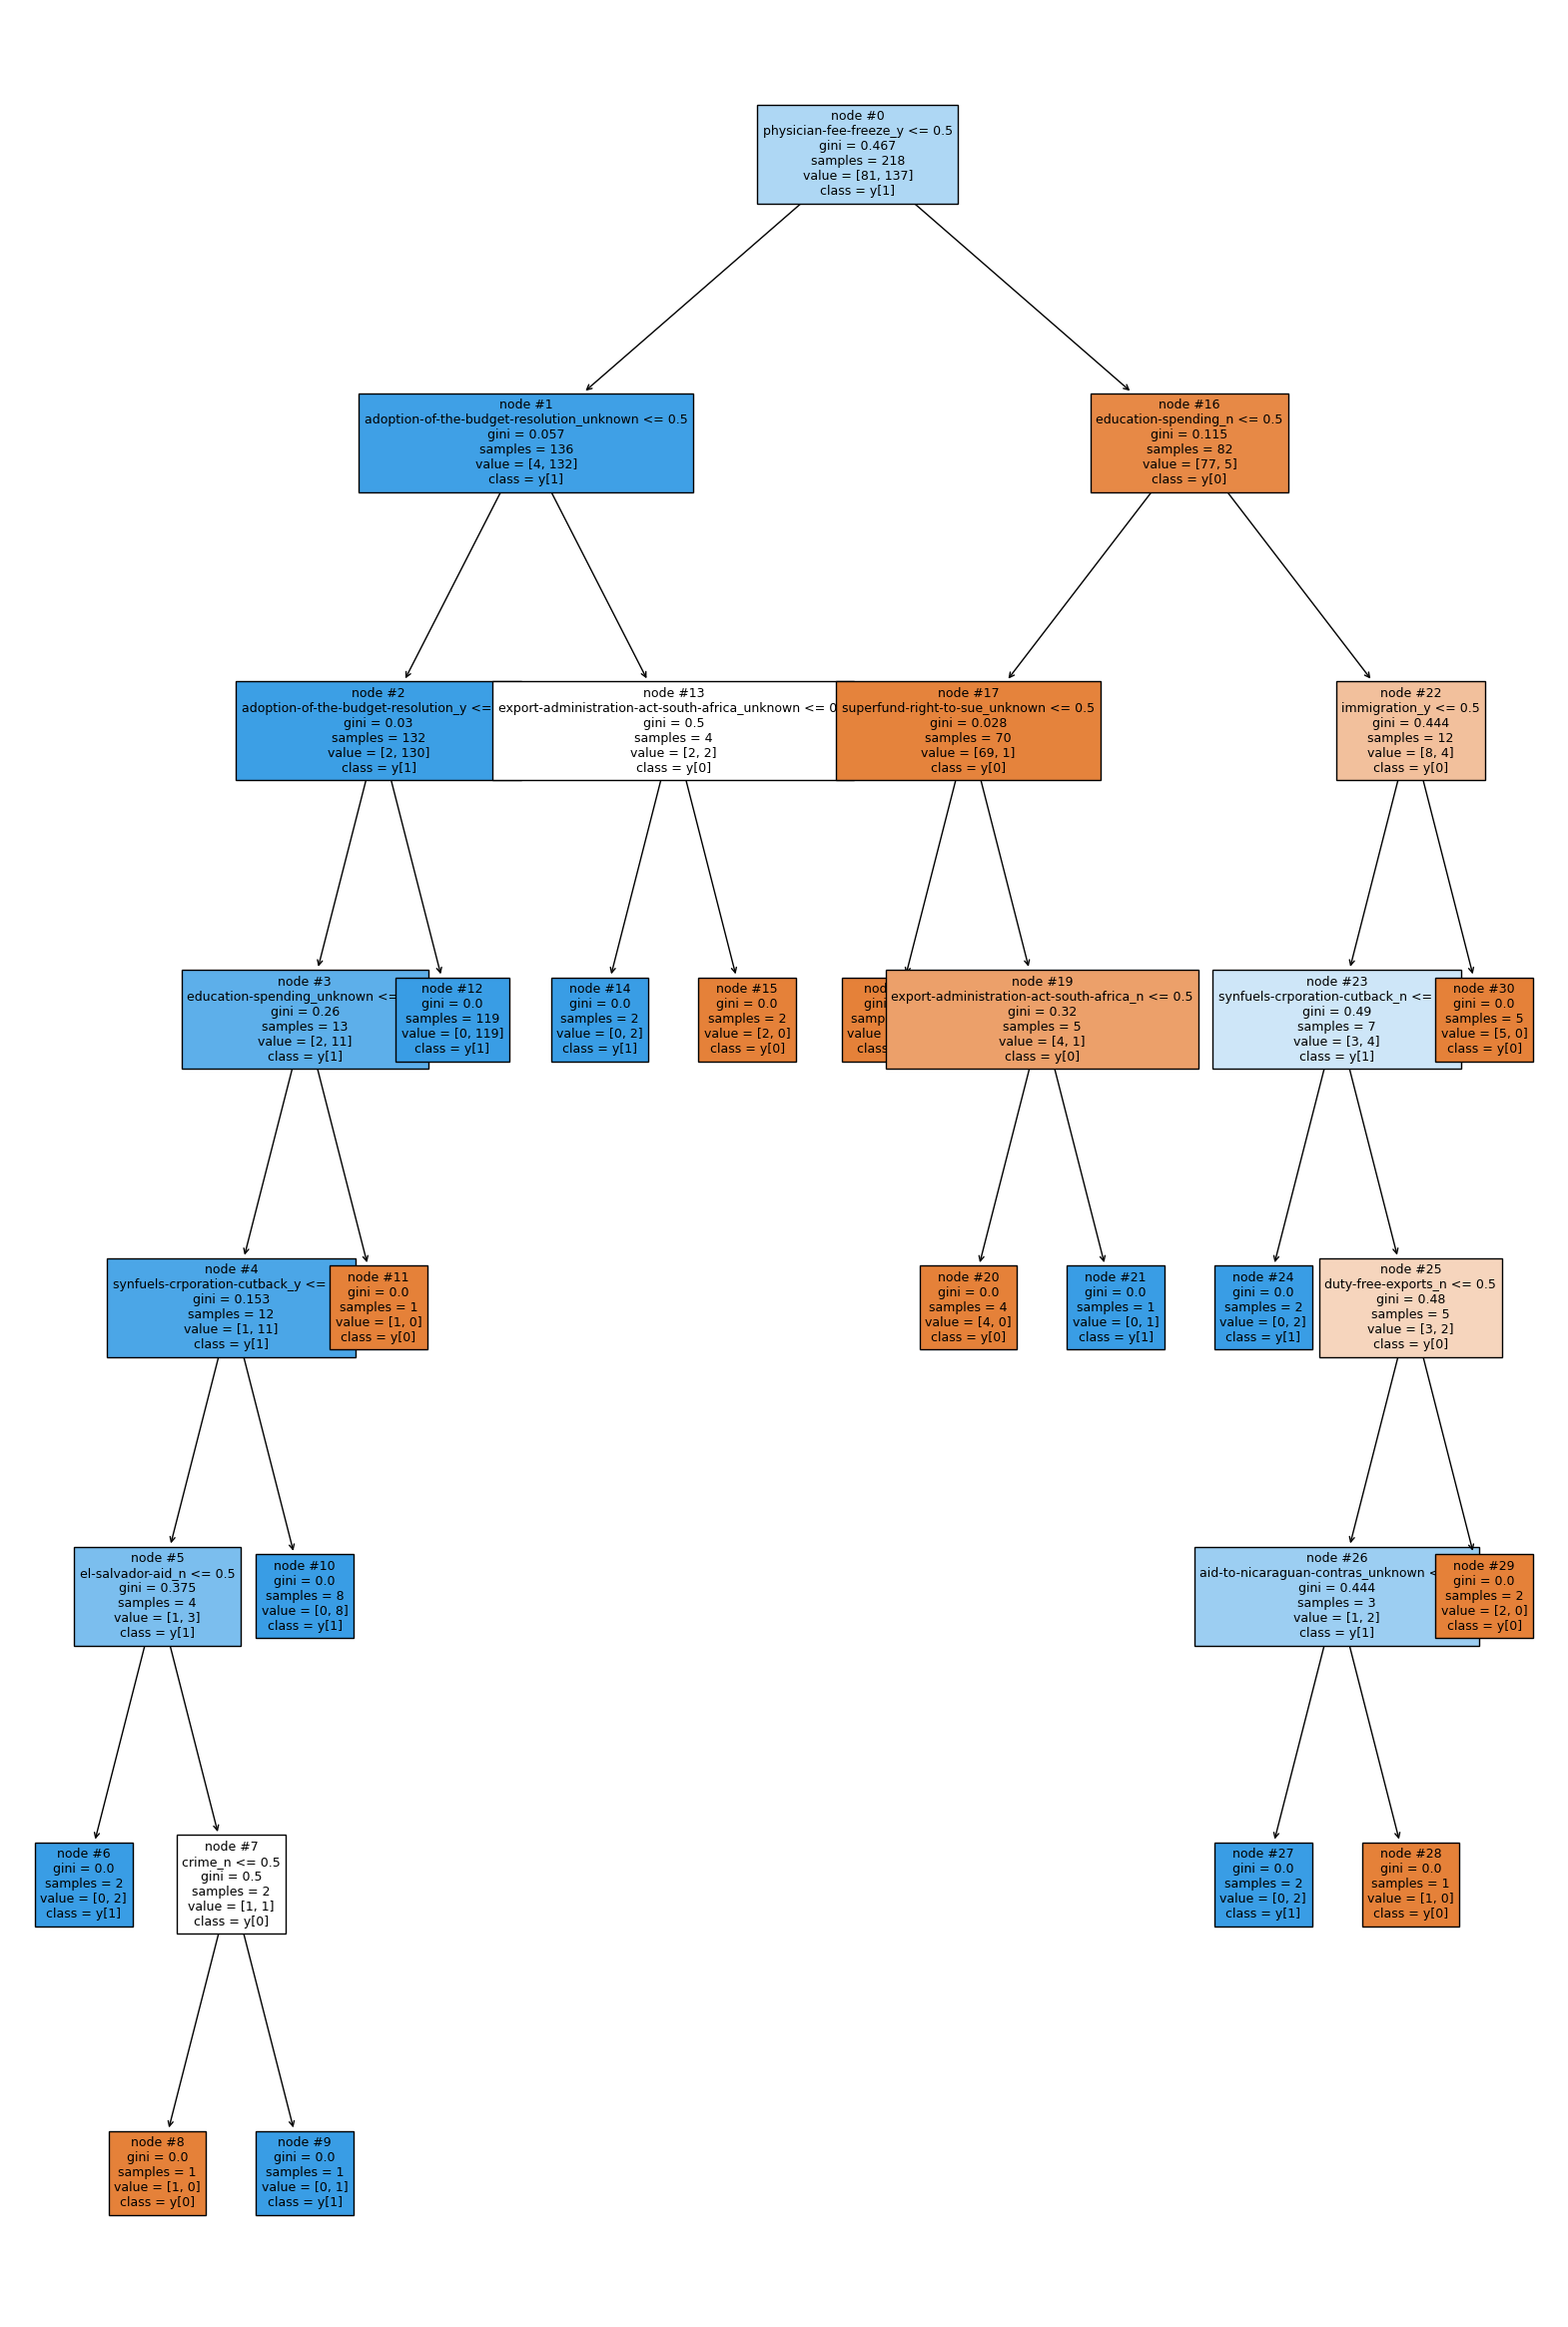

In [351]:
plottree(tree_1)

In [352]:
feat_dict_1= {}
for col, val in sorted(zip(features, tree_1.feature_importances_),key=lambda x:x[1],reverse=True):
        feat_dict_1[col]=val
feat_df_1 = pd.DataFrame({'Feature':feat_dict_1.keys(),'Importance':feat_dict_1.values()})

In [353]:
# function for plotting the features
def plot_features(model):
    feat_dict= {}
    for col, val in sorted(zip(features, model.feature_importances_),key=lambda x:x[1],reverse=True):
        feat_dict[col]=val
    feat_df = pd.DataFrame({'Feature':feat_dict.keys(),'Importance':feat_dict.values()})
    values = feat_df.Importance    
    idx = feat_df.Feature
    plt.figure(figsize=(10,8))
    clrs = ['navy']
    sns.barplot(y=idx,x=values,palette=clrs).set(title='Important features to predict client subscription')
    plt.show()

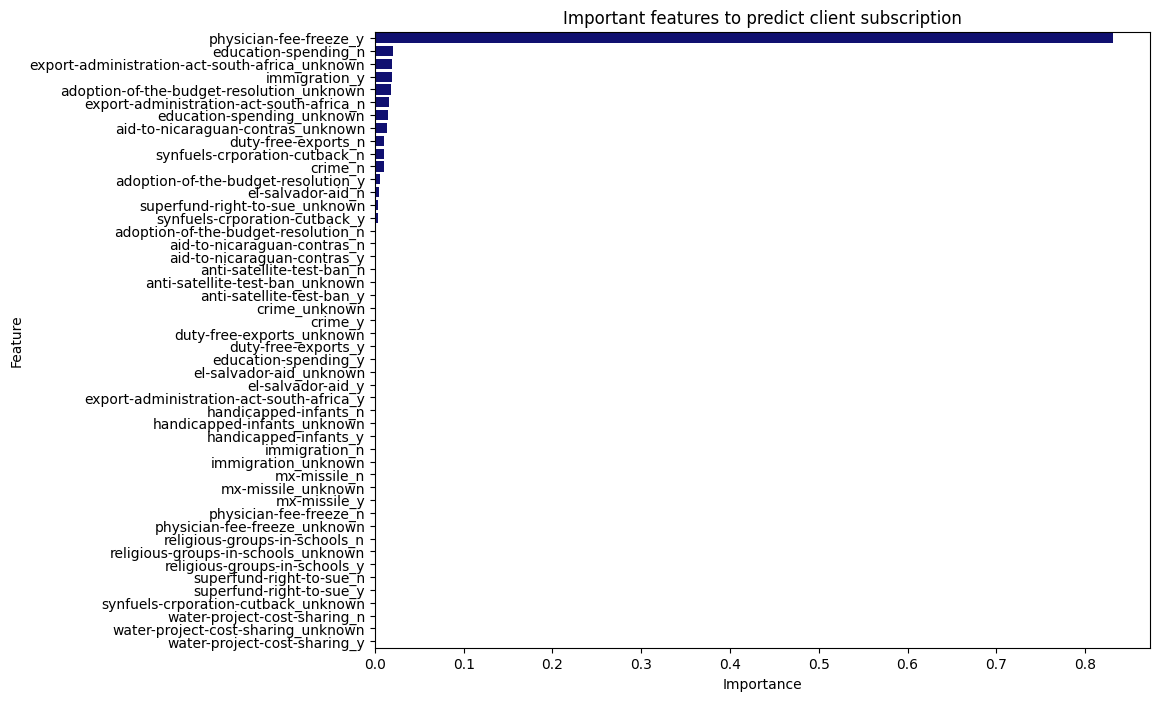

In [203]:
plot_features(tree_1)

Observations:
- The most important features include `physician-fee-freeze_n`, `synfuels-crporation-cutback_n`,  `duty-free-exports-unknown`, `education-spending_n`,`mix-missile_y`,`adoption-of-the-budget-resolution_n`, `export-administration-act-south-africa_n`, `crime_y`, `duty-free-exports_y`, `superfund-right-to-sue_n` and `immigration_n`.

#### Fitting a model with the most important features

In [354]:
X_train_new = X_train[feat_df_1[:11].Feature.to_list()]
X_test_new = X_test[feat_df_1[:11].Feature.to_list()]

In [355]:
tree_2 = tree.DecisionTreeClassifier(random_state=1)

####################
Accuracy on train:  0.9908256880733946
Accuracy on test:  0.5576036866359447
####################
Recall on train:  0.9927007299270073
Recall on test:  0.5576036866359447
####################
Precision on train:  0.9927007299270073
Precision on test:  1.0


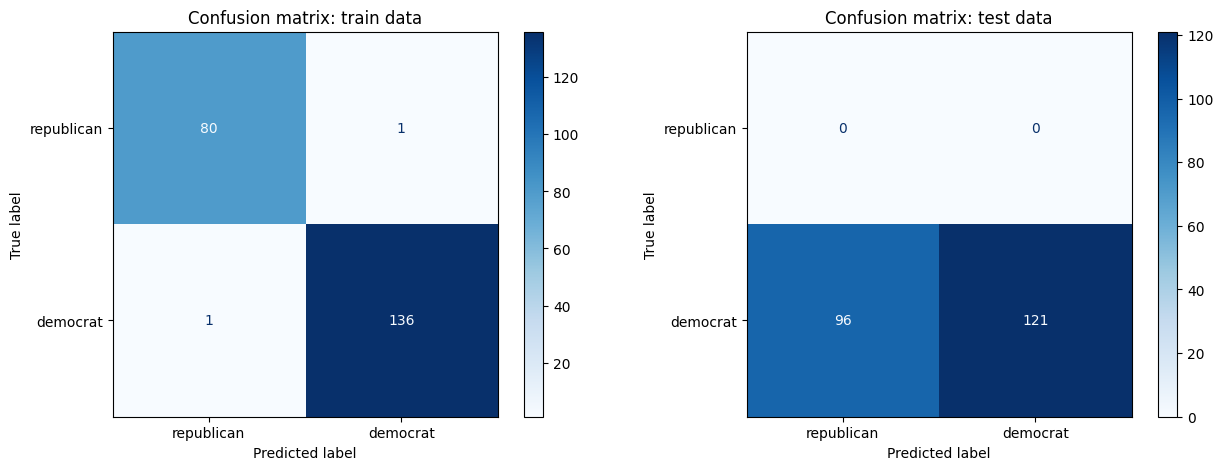

In [356]:
evaluate(tree_2,X_train = X_train_new,X_test = X_test_new)

Observations:
As seen above, fitting the model on the most important features leads only to a low improvement.

#### Weighted Tree

In [357]:
tree_3 = tree.DecisionTreeClassifier(class_weight = {1:0.40,0:0.60},random_state=1,)

####################
Accuracy on train:  1.0
Accuracy on test:  0.5529953917050692
####################
Recall on train:  1.0
Recall on test:  0.5529953917050692
####################
Precision on train:  1.0
Precision on test:  1.0


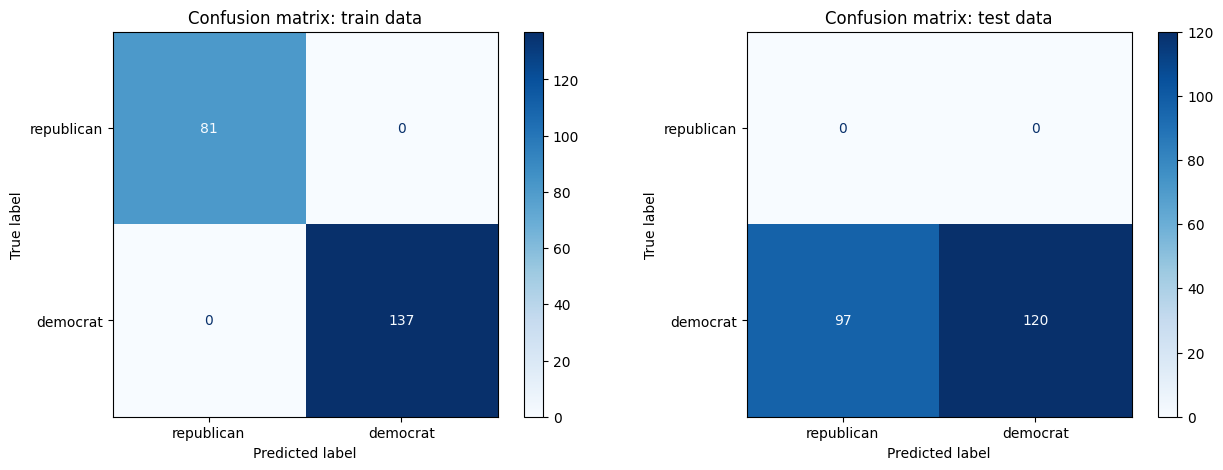

In [358]:
evaluate(tree_3)

Observations:
- The model overfit has not decreased. The perfomance on test does not differ from the first version.

#### Oversampling the minority class

In [359]:
from imblearn.over_sampling import RandomOverSampler
ratio = 1  # ratio of majority class to minority class

oversampler = RandomOverSampler( random_state=1)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

In [360]:
n_minority = len(y_train_resampled[y_train_resampled == 0])
n_majority = len(y_train_resampled[y_train_resampled == 1])
print(n_minority, n_majority)

137 137


####################
Accuracy on train:  1.0
Accuracy on test:  0.576036866359447
####################
Recall on train:  1.0
Recall on test:  0.576036866359447
####################
Precision on train:  1.0
Precision on test:  1.0


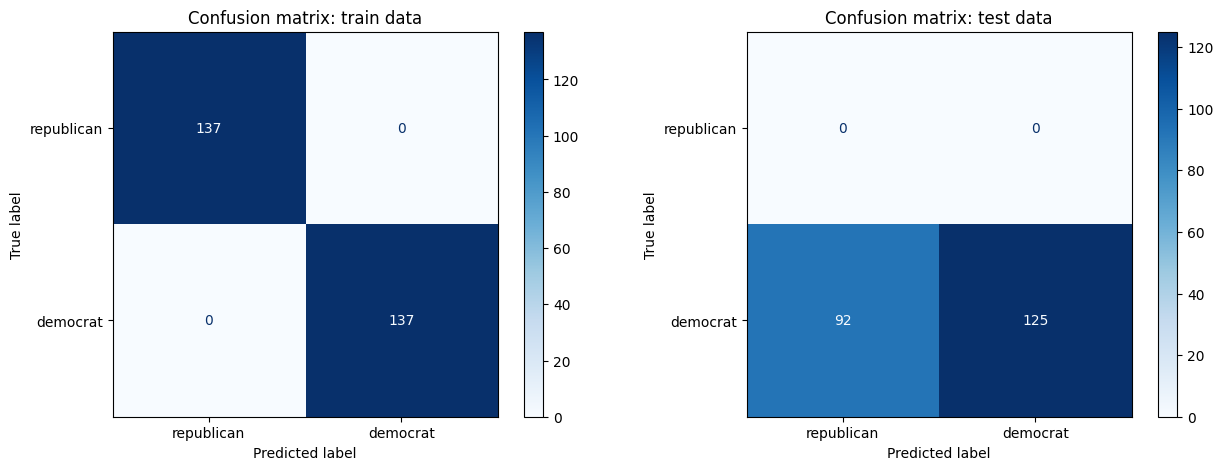

In [361]:
tree_4 = tree.DecisionTreeClassifier(random_state=1)
evaluate(tree_4,X_train = X_train_resampled,y_train = y_train_resampled)

Observations:
- As seen above, our decision tree on oversampled data did not experience any significant improvement.

##### Grid search for paramter tuning

In [362]:
estimator  = tree.DecisionTreeClassifier(random_state=1)

parameters = {'max_depth': np.arange(1,20), 
              'max_leaf_nodes' : [5,10,15,20,25,30,35,40,45,50],
              'criterion': ['gini','entropy','log_loss']}
              
scorer = make_scorer(accuracy_score)

grid = GridSearchCV(estimator = estimator,param_grid = parameters,scoring = scorer, cv = 5)
grid = grid.fit(X_train,y_train)

In [363]:
#best combination
tree_best = grid.best_estimator_
tree_best

DecisionTreeClassifier(max_depth=1, max_leaf_nodes=5, random_state=1)

####################
Accuracy on train:  0.9587155963302753
Accuracy on test:  0.5622119815668203
####################
Recall on train:  0.9635036496350365
Recall on test:  0.5622119815668203
####################
Precision on train:  0.9705882352941176
Precision on test:  1.0


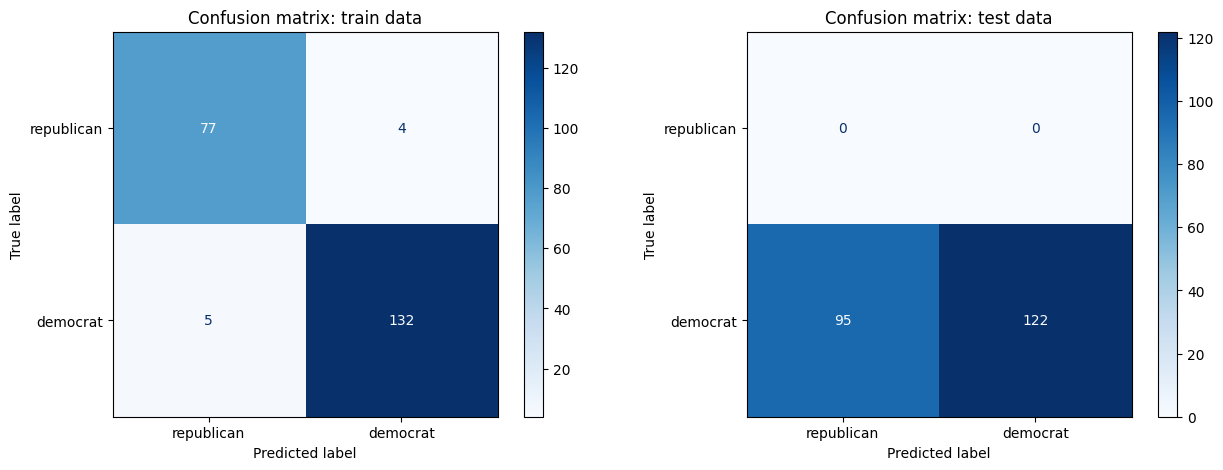

In [364]:
evaluate(tree_best)


Observations:
- Even the "best" model does not have a much improved performance. But at least overfit has decreased.

##### Cost complexity pruning

In [365]:
tree_ = tree.DecisionTreeClassifier(random_state = 1)
ccp = tree_.cost_complexity_pruning_path(X_train,y_train)
ccp_alphas, impurities = ccp.ccp_alphas, ccp.impurities

In [366]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = tree.DecisionTreeClassifier(random_state=1,ccp_alpha = ccp_alpha)
    clf.fit(X_train,y_train)
    clfs.append(clf)

In [367]:
def plot_ccp(clfs):
    train_acc = []
    test_acc = []

    for c in clfs:
        y_train_predict = c.predict(X_train)
        y_test_predict = c.predict(X_test)
        train_acc.append(accuracy_score(y_train,y_train_predict))
        test_acc.append(accuracy_score(y_test,y_test_predict))

    plt.scatter(ccp_alphas,train_acc)
    plt.scatter(ccp_alphas,test_acc)
    plt.plot(ccp_alphas,train_acc,label='train_accuracy',drawstyle = 'steps-post')
    plt.plot(ccp_alphas,test_acc,label = 'test_accuracy',drawstyle = 'steps-post')
    plt.legend()
    plt.title('Accuracy vs Alpha')
    plt.show()

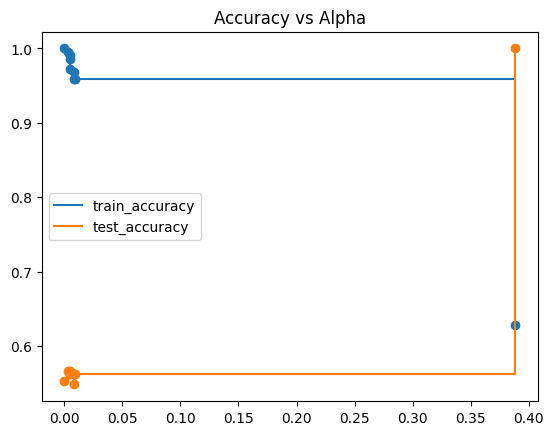

In [368]:
plot_ccp(clfs)

Observations:
- According to the picture above, there was not much we could improve by using post-pruning.

#### Random Forest
##### Random Forest 1

In [407]:
#instatiating a model with 1000 trees
rf_1 = RandomForestClassifier(random_state = 1)


####################
Accuracy on train:  1.0
Accuracy on test:  0.5576036866359447
####################
Recall on train:  1.0
Recall on test:  0.5576036866359447
####################
Precision on train:  1.0
Precision on test:  1.0


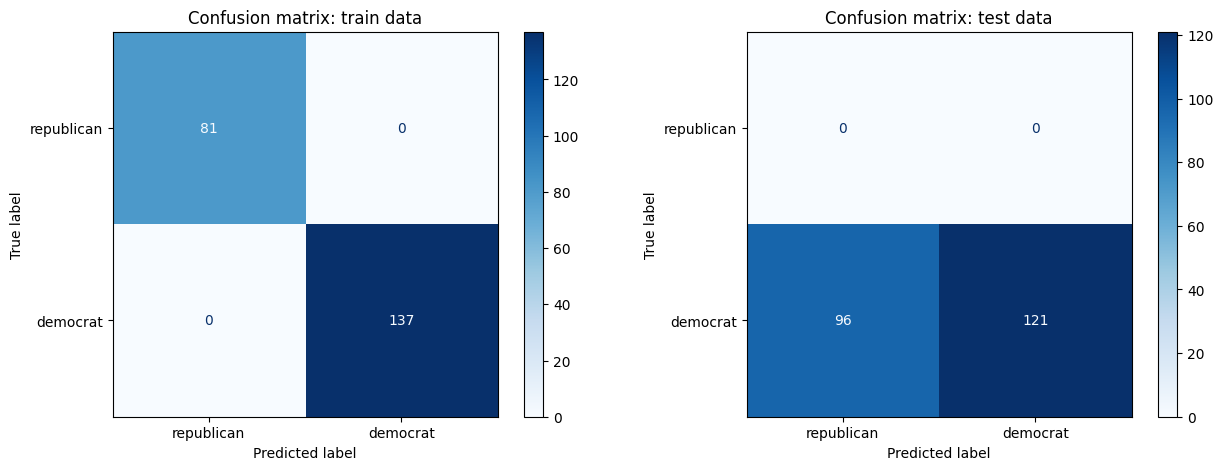

In [408]:
evaluate(rf_1)

##### Random Forest 2

In [419]:
rf_2 = RandomForestClassifier(random_state = 1,class_weight = 'balanced')

####################
Accuracy on train:  1.0
Accuracy on test:  0.5529953917050692
####################
Recall on train:  1.0
Recall on test:  0.5529953917050692
####################
Precision on train:  1.0
Precision on test:  1.0


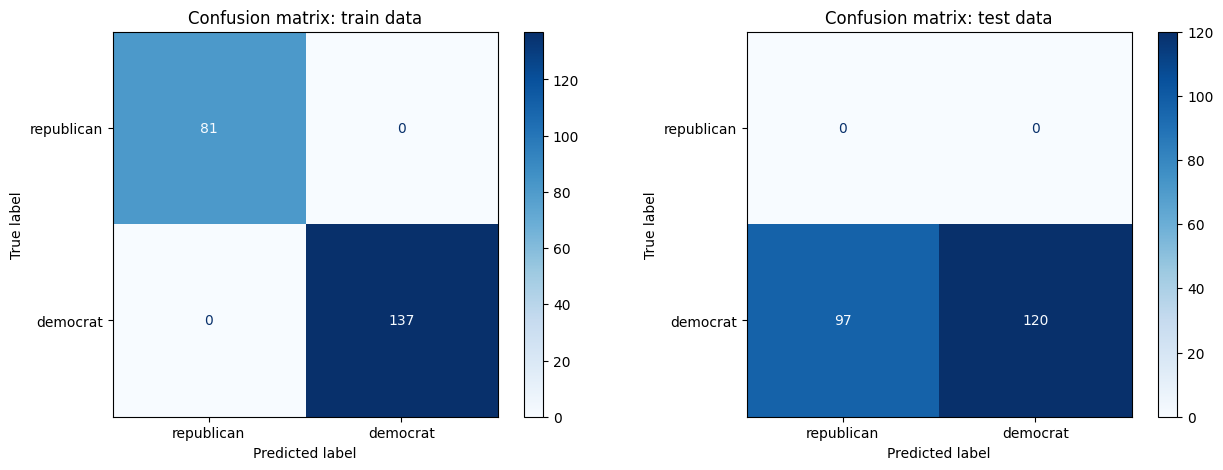

In [420]:
evaluate(rf_2)

##### Hyperparameter Tuning

In [411]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True,False],
    'max_depth': [80, 90, 100, 110,130,150,170],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000],
    'class_weight':[None,'balanced']
}
# Create a based model
rf = RandomForestClassifier(random_state = 1)
scorer = make_scorer(accuracy_score)
# Instantiate the grid search model
grid_search_rf = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2,scoring = scorer)

In [414]:
grid_search_rf.fit(X_train, y_train)

Fitting 5 folds for each of 2016 candidates, totalling 10080 fits
[CV] END bootstrap=True, class_weight=None, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, class_weight=None, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, class_weight=None, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, class_weight=None, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, class_weight=None, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, class_weight=None, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200; total time=   1.0s
[CV] END bootstrap=Tru

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'class_weight': [None, 'balanced'],
                         'max_depth': [80, 90, 100, 110, 130, 150, 170],
                         'max_features': [2, 3], 'min_samples_leaf': [3, 4, 5],
                         'min_samples_split': [8, 10, 12],
                         'n_estimators': [100, 200, 300, 1000]},
             scoring=make_scorer(accuracy_score), verbose=2)

In [423]:
rf_best = grid_search_rf.best_estimator_
rf_best

RandomForestClassifier(class_weight='balanced', max_depth=80, max_features=3,
                       min_samples_leaf=3, min_samples_split=8,
                       n_estimators=1000, random_state=1)

####################
Accuracy on train:  0.9724770642201835
Accuracy on test:  0.5529953917050692
####################
Recall on train:  0.9708029197080292
Recall on test:  0.5529953917050692
####################
Precision on train:  0.9851851851851852
Precision on test:  1.0


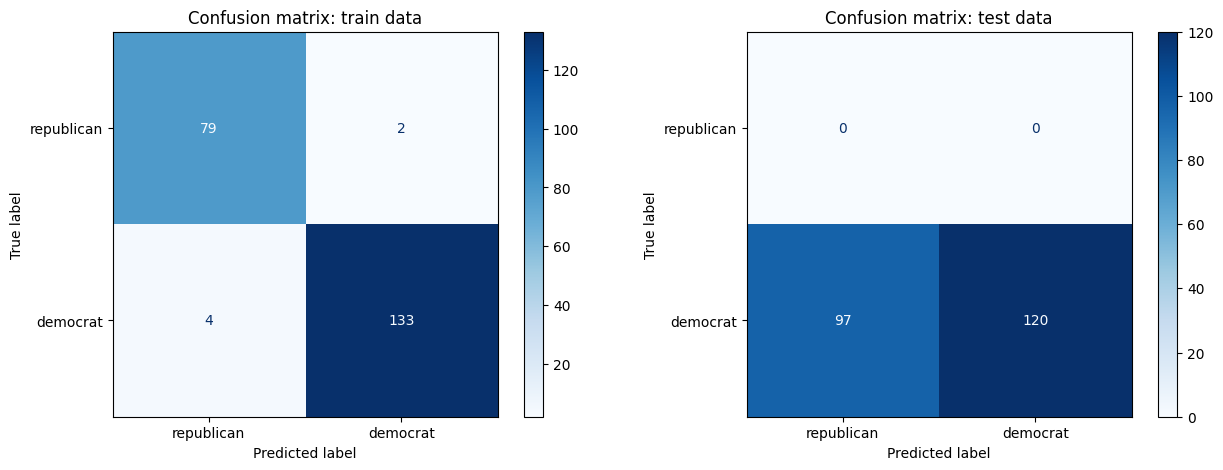

In [424]:
evaluate(rf_best)